In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import os
import glob
import time
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
from scipy.stats import norm
from dask.diagnostics import ProgressBar
from dask.distributed import Client, LocalCluster

#### This script grabs slices from Tuolumne Basin by the 'x' and 'y' UTMs.
##### pix = variable that defines the number of pixels in each direction from a midpoint. 
      **NOTE** - pix variable is in there twice! Change for both or correct to just one location when running a new area!!
##### pix_value * 2 is the distance for the box size. 

## ADD LIDAR DATA
##### open inputs

In [2]:
fname = '/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow.nc' #3m BSU
# fname = '/Users/megmason/research/sierra/data/compiled_SUPERsnow_20m.nc' #20m mac #CAREFUL THIS IS 20m DATA

#open data
ds = xr.open_dataset(fname, chunks={'time':1,'x':1000,'y':1000})
ds['snow'] = ds.snow / 10
ds.attrs['units'] = 'cm'
ds=ds.astype(np.int16, copy=False)
ds.close()
ds

<xarray.Dataset>
Dimensions:  (time: 51, x: 17567, y: 16780)
Coordinates:
  * y        (y) float64 4.23e+06 4.23e+06 4.23e+06 ... 4.179e+06 4.179e+06
  * x        (x) float64 2.54e+05 2.54e+05 2.54e+05 ... 3.067e+05 3.067e+05
  * time     (time) datetime64[ns] 2013-04-03 2013-04-29 ... 2018-05-28
    mask     (y, x) uint8 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    dem      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    veg      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
    srf      (y, x) float32 dask.array<chunksize=(1000, 1000), meta=np.ndarray>
Data variables:
    snow     (time, y, x) int16 dask.array<chunksize=(1, 1000, 1000), meta=np.ndarray>

##### clip and plot

dana meadow
x direction length 3000.0 [m]:
y direction length 3000.0 [m]:
tuolumne meadow
x direction length 3000.0 [m]:
y direction length 3003.0 [m]:
slide canyon
x direction length 3000.0 [m]:
y direction length 3003.0 [m]:


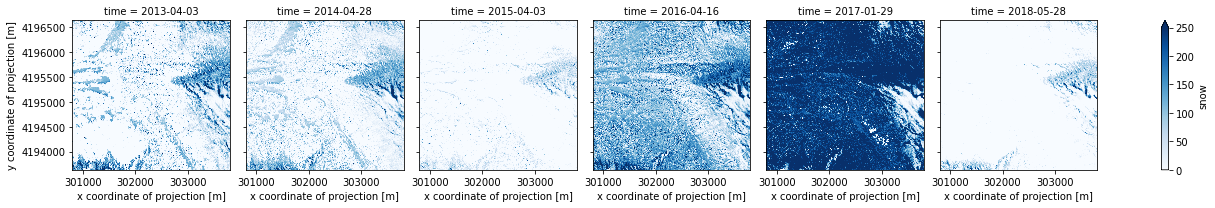

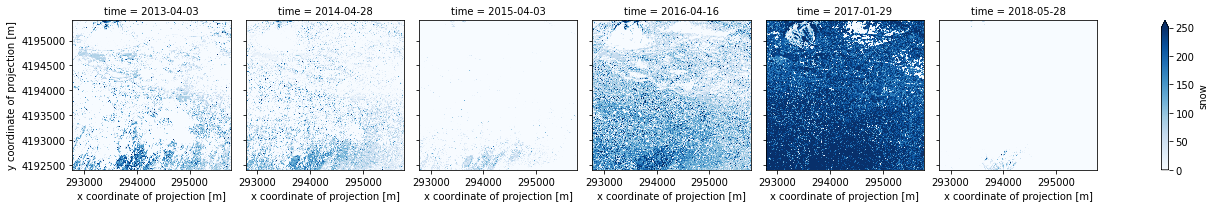

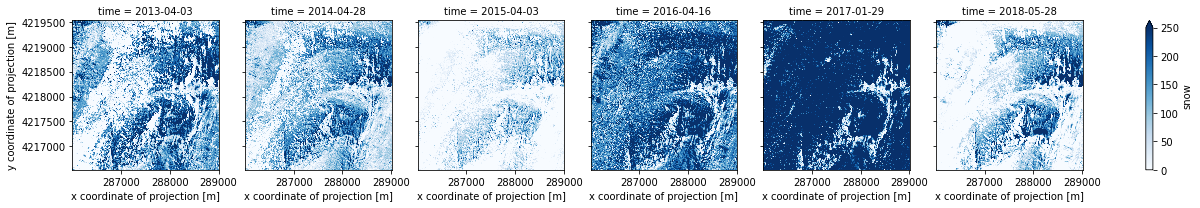

In [3]:
#station slices
pix = 702 #multipy by 2 to get x and y distance of box sz (cheatsheet: 15=30m, 75=150m, 501=1000m...yes 501)
pix_2 = 2300
dan = ds.sel(x=slice(301506.-pix, 301506.+pix_2), y=slice(4196685.+(pix-750), 4196685.-(pix_2+750))) #x=301506.26, y=4196685.89
tum = ds.sel(x=slice(293484.-pix, 293484.+pix_2), y=slice(4194702.+pix, 4194701.-pix_2)) #x=293484.72, y=4194701.07
sli = ds.sel(x=slice(286708.-pix, 286710.+pix_2), y=slice(4218828.+pix, 4218826.-pix_2)) #x=286708.13, y=42188826.62 #due to rounding, made x and y have 2 pix apart

# # dan.isel(time=32).snow.plot()
d = dan.isel(time=slice(0,51,10)).snow.plot(x='x', y='y', cmap='RdBu', col='time', vmax=250)
t = tum.isel(time=slice(0,51,10)).snow.plot(x='x', y='y', cmap='RdBu', col='time', vmax=250)
s = sli.isel(time=slice(0,51,10)).snow.plot(x='x', y='y', cmap='RdBu', col='time', vmax=250)

print('dana meadow')
print('x direction length {} [m]:'.format(dan.x.max().values - dan.x.min().values))
print('y direction length {} [m]:'.format(dan.y.max().values - dan.y.min().values))

print('tuolumne meadow')
print('x direction length {} [m]:'.format(tum.x.max().values - tum.x.min().values))
print('y direction length {} [m]:'.format(tum.y.max().values - tum.y.min().values))

print('slide canyon')
print('x direction length {} [m]:'.format(sli.x.max().values - sli.x.min().values))
print('y direction length {} [m]:'.format(sli.y.max().values - sli.y.min().values))

##### save output

In [4]:
#grab box size for output filename
bx_sz = round(pix+pix_2, -1)

#save station boxes as netCDFs
dan.to_netcdf('/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow_{}m_dan.nc'.format(bx_sz))
tum.to_netcdf('/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow_{}m_tum.nc'.format(bx_sz))
sli.to_netcdf('/Users/meganmason491/Documents/research/sierra/data/compiled_SUPERsnow_{}m_sli.nc'.format(bx_sz))

## ADD TERRAIN DATA
##### open inputs

In [5]:
fpath = '/Users/meganmason491/Documents/research/sierra/data/terrain/*flipped*.nc' #BSU
# fpath = '' #mac

terrain=xr.open_mfdataset(fpath, 
                          concat_dim=None, 
                          combine='nested', 
                          chunks={'x':1000, 'y':1000}, 
                          parallel=True) 
terrain = terrain.where(ds.mask==1)
terrain.close()

##### clip and plot

hillshade


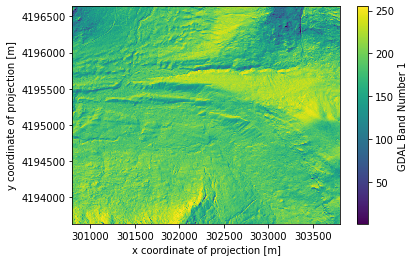

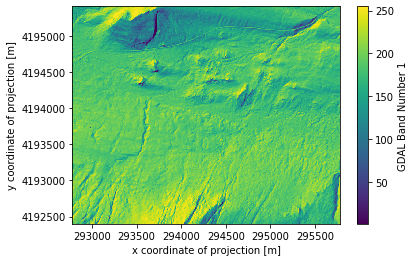

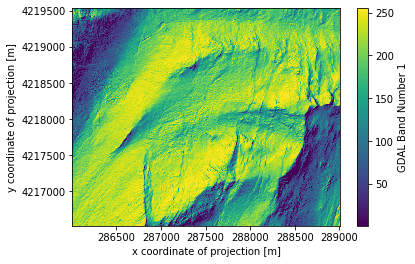

aspect


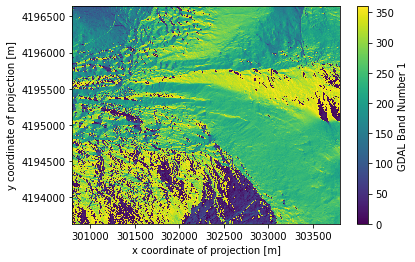

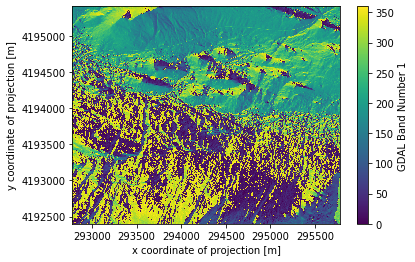

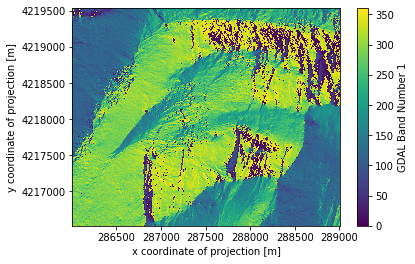

slope


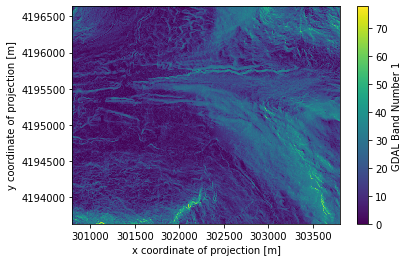

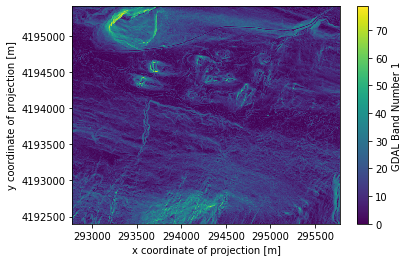

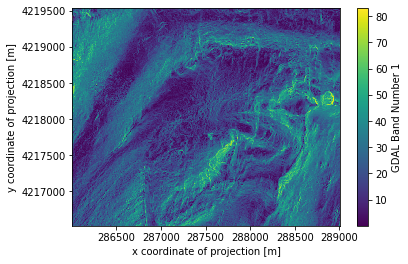

dana meadow
x direction length 3000.0 [m]:
y direction length 3000.0 [m]:
tuolumne meadow
x direction length 3000.0 [m]:
y direction length 3003.0 [m]:
slide canyon
x direction length 3000.0 [m]:
y direction length 3003.0 [m]:


In [6]:
#station slices (for terrain)
pix = 702 #multipy by 2 to get x and y distance of box sz (cheatsheet: 15=30m, 75=150m, 501=1000m...yes 501, 702/3300=4000m)
pix_2 = 2300
t_dan = terrain.sel(x=slice(301506.-pix, 301506.+pix_2), y=slice(4196685.+(pix-750), 4196685.-(pix_2+750))) #x=301506.26, y=4196685.89
t_tum = terrain.sel(x=slice(293484.-pix, 293484.+pix_2), y=slice(4194702.+pix, 4194701.-pix_2)) #x=293484.72, y=4194701.07
t_sli = terrain.sel(x=slice(286708.-pix, 286710.+pix_2), y=slice(4218828.+pix, 4218826.-pix_2)) #x=286708.13, y=42188826.62 #due to rounding, made x and y have 2 pix apart


vlist=['hillshade', 'aspect', 'slope'] #plots could be improved (ie more labels and colors....but that's for later!)
for var in vlist:
    print(var)
    h = t_dan[var].plot.imshow(label=var); plt.show()
    a = t_tum[var].plot.imshow(label=var); plt.show()
    s = t_sli[var].plot.imshow(label=var); plt.show()

print('dana meadow')
print('x direction length {} [m]:'.format(t_dan.x.max().values - t_dan.x.min().values))
print('y direction length {} [m]:'.format(t_dan.y.max().values - t_dan.y.min().values))

print('tuolumne meadow')
print('x direction length {} [m]:'.format(t_tum.x.max().values - t_tum.x.min().values))
print('y direction length {} [m]:'.format(t_tum.y.max().values - t_tum.y.min().values))

print('slide canyon')
print('x direction length {} [m]:'.format(t_sli.x.max().values - t_sli.x.min().values))
print('y direction length {} [m]:'.format(t_sli.y.max().values - t_sli.y.min().values))

##### save output

In [7]:
#grab box size for output filename
bx_sz = round(pix+pix_2, -1)
print(bx_sz)
#save terrain station boxes as netCDFs
t_dan.to_netcdf('/Users/meganmason491/Documents/research/sierra/data/terrain/terrainMet_{}m_dan.nc'.format(bx_sz))
t_tum.to_netcdf('/Users/meganmason491/Documents/research/sierra/data/terrain/terrainMet_{}m_tum.nc'.format(bx_sz))
t_sli.to_netcdf('/Users/meganmason491/Documents/research/sierra/data/terrain/terrainMet_{}m_sli.nc'.format(bx_sz))

3000


##### Running list of specific cordinates

In [8]:
# DATE: 3-9-2020
#~~~~30, 150, and 1000 m boxes
# dan = ds.sel(x=slice(301506.-pix, 301506.+pix), y=slice(4196685.+pix, 4196685.-pix)) #x=301506.26, y=4196685.89 = Dana Meadow SNOTEL
# tum = ds.sel(x=slice(293484.-pix, 293484.+pix), y=slice(4194702.+pix, 4194701.-pix)) #x=293484.72, y=4194701.07 = Tuolumne Meadow SNOTEL
# sli = ds.sel(x=slice(286708.-pix, 286710.+pix), y=slice(4218828.+pix, 4218826.-pix)) #x=286708.13, y=42188826.62 = Slide Canyon SNOTEL

# DATE: 